In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib
import cv2
import PIL

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import io
import scipy.misc
from six import BytesIO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import io
import html
import time

In [ ]:
%%bash
# Clone the tensorflow models repository
git clone --depth 1 https://github.com/tensorflow/models

# API Installation 
sudo apt install -y protobuf-compiler
cd models/research
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-comput

Cloning into 'models'...


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
%cd models/research
# Test the installation.
''' If the output shows, [OK] then we're good to go'''
!python object_detection/builders/model_builder_tf2_test.py

/content/models/research
Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-02-18 08:10:16.145926: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0218 08:10:17.205906 140484021544832 model_builder.py:1100] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 5.09s
I0218 08:10:17.903666 140484021544832 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 5.09s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 1.65s
I0218 08:10:19.55

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [ ]:
faster_rcnn_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# Load model from tensorflow hub
print('loading model...')
detector = hub.load(faster_rcnn_url).signatures['default']
print('model loaded!')


loading model...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


model loaded!


In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.axis('off')
  plt.imshow(image)

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def draw(image, max_boxes, min_score, boxes, class_names, scores):
  
 
  
  # get color values from PIL.Image.Color 
  colors = list(ImageColor.colormap.values())

  # get font name from PIL.ImageFont
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                            25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  detected_boxes = boxes.shape[0] 

  for i in range(min(max_boxes, detected_boxes)):
    if scores[i] >= min_score: # if detection score >= your desired score

      ymin, xmin, ymax, xmax = tuple(boxes[i]) # bbox coordinate values
      
      # decode detected object name with score
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), 
                                     int(100 * scores[i]))
      
      # set bbox color same to every same class
      color = colors[hash(class_names[i]) % len(colors)]

      # Convert Image to numpy type and RGB
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      draw_bbox_text_on_image(
          image_pil,
          ymin, xmin,
          ymax, xmax,
          color, font,
          display_str_list=[display_str]
      )
      np.copyto(image, np.array(image_pil))

  return image   

def draw_bbox_text_on_image(image,
                            ymin, xmin,
                            ymax, xmax,
                            color, font, thickness=4,
                            display_str_list=()):
  
    

    # creates PIL Draw Object  
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size

    # Formula for bbox coordinate calculation 
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    
    # Draw bbox with coordinates 
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
              (left, top)],
              width=thickness,
              fill=color)

    # get font size from String list
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list] # 11

    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights) # 12
    

    # calculation for showing better class label position with bbox 
    if top > total_display_str_height:
      text_bottom = top
    else:
      text_bottom = top + total_display_str_height
      
    for display_str in display_str_list:
      text_width, text_height = font.getsize(display_str)
      margin = np.ceil(0.05 * text_height)
      
      # draw rectangle with color 
      draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                      (left + text_width, text_bottom)],
                    fill=color)
      
      # put text in drawn colored rectangle 
      draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)

In [ ]:
def run_detector(detector, path, max_boxes, max_score):
 

  img = load_img(path)

  # convert jpeg into tf.float32 fromat and add batchsize 1 as dimension 
  converted_img= tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  print('Detecting Image ...')
  output = detector(converted_img) # Returns a dictionary containing bbox values, classnames, scores
  print('Detection Complete\n')

  for key, value in output.items():
    print(f'Key:{key}\nValue:{value}\n\n')
  
  output = {key:value.numpy() for key,value in output.items()}
  print("Found %d objects." % len(output["detection_scores"]))

  image_with_boxes = draw(img.numpy(),
                          max_boxes, max_score,
                          output['detection_boxes'],
                          output['detection_class_entities'], 
                          output['detection_scores'])
  display_image(image_with_boxes)

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array) # numpy array into PIL image object
  iobuf = io.BytesIO()
  
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')

  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<div class="video_container">
  <video autoplay
   width=%d height=%d></video>
  <div style='position: absolute;top: 40px; left: 40px; font-size: 40px; color: green;'>Click to save!</div>
</div>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(filename=None, quality=0.8, size=(800,600)):
  """ Take photo from webcam and save it"""
  handle = display(HTML(VIDEO_HTML % (size[0],size[1],quality)), display_id='videoHTML')
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  if filename:
    f = io.BytesIO(binary)
    Image.open(f).save(filename)
  else:
    f = io.BytesIO(binary)
    return np.asarray(Image.open(f))

take_photo('me.jpg')

In [ ]:
def run_inference_for_single_image(model, image, live_cam):
    
    # convert image into numpy
    image = np.asarray(image)
    #print('Converted image into numpy type:', type(image))
    
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    #print('Converted numpy into tensor format:', input_tensor)
    
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]
    
    # Run inference
    if not live_cam:
      start_time = time.time()
      output_dict = model(input_tensor)
      end_time = time.time()
      print(f"Inference time: {np.ceil(end_time-start_time)} seconds per frame")

    output_dict = model(input_tensor)
    num_detections = int(output_dict.pop('num_detections')) # 300

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    
    output_dict = {key: value[0, :num_detections].numpy()
                   for key, value in output_dict.items()}
    
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

def run_inference_video(model, video_path, live_cam):
  cap = cv2.VideoCapture(video_path)
  if cap.isOpened():
      width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      res=(int(width), int(height))

      # save detected video
      # Initialize our video writer
      fourcc = cv2.VideoWriter_fourcc(*"XVID") #codec
      out = cv2.VideoWriter('../../detected_output.avi', fourcc, 20.0, res)
      frame = None

      while True:
          try:
              is_success, image_np = cap.read()
          except cv2.error:
              continue

          if not is_success:
              break

          # Actual detection.
          output_dict = run_inference_for_single_image(model, image_np, live_cam)
          
          # Visualization of the results of a detection.
          viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks_reframed', None),
              use_normalized_coordinates=True,
              line_thickness=8)

          out.write(image_np)

      out.release() 

      # OPTIONAL: show last image
      if frame:
        cv2_imshow(frame)

  cap.release()

In [ ]:
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

model_handle = 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1'

print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


Detecting Image ...
Detection Complete

Key:detection_boxes
Value:[[1.30687028e-01 5.12021780e-01 9.67328310e-01 8.00131261e-01]
 [1.32040665e-01 3.92044157e-01 9.34545696e-01 7.62788653e-01]
 [1.22137964e-01 7.86708016e-03 9.85852599e-01 9.00600553e-01]
 [6.59301519e-01 4.52101324e-03 1.00000000e+00 2.60701448e-01]
 [2.26178065e-01 1.36443749e-01 7.30104387e-01 5.78430116e-01]
 [1.26942858e-01 5.38602797e-03 9.84864831e-01 6.78743362e-01]
 [1.13258213e-01 8.20097863e-04 9.85998333e-01 5.34441173e-01]
 [2.81355381e-01 2.50374168e-01 1.00000000e+00 8.79644096e-01]
 [7.19821751e-01 7.84515977e-01 9.98680532e-01 9.29762065e-01]
 [1.38177067e-01 0.00000000e+00 5.40796936e-01 1.78601012e-01]
 [6.70648277e-01 4.01271693e-02 9.21821535e-01 2.33162060e-01]
 [2.19765753e-01 1.48875341e-01 8.75489652e-01 7.06949353e-01]
 [6.26482785e-01 1.23447575e-01 1.00000000e+00 1.00000000e+00]
 [3.14568013e-01 2.44684726e-01 1.00000000e+00 8.71731520e-01]
 [1.49140060e-01 0.00000000e+00 4.24759477e-01 1.714

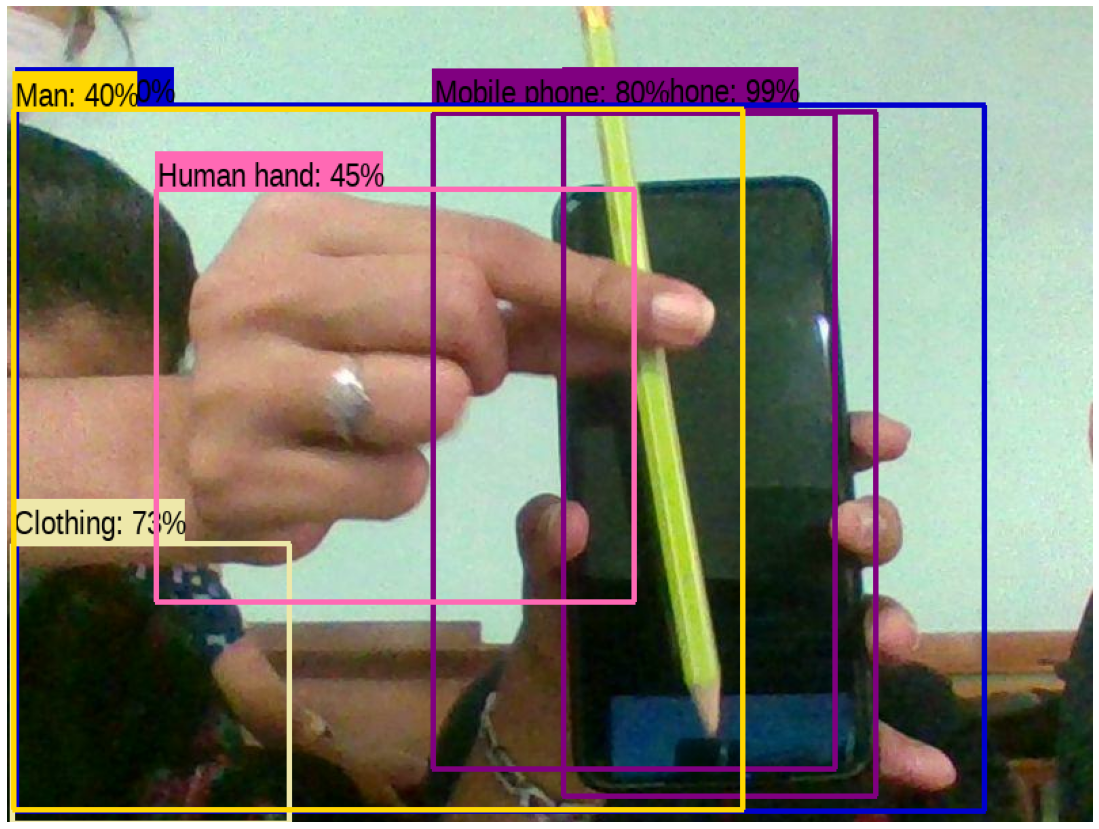

In [ ]:
run_detector(detector, 'me.jpg',  max_boxes=10, max_score=0.3) # >=20% accuracy  

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = None
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Actual detection.
    output_dict = run_inference_for_single_image(hub_model, img, live_cam=True)

    # Visualization of the results of a detection.
    viz_utils.visualize_boxes_and_labels_on_image_array(
        img,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    
    # Convert OpenCV BGR format to RGB format 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert numpy image type to Base64 image byte string type
    # for JavaScript Video object 
    bbox_bytes = bbox_to_bytes(img)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>